# Atividade 7
# Teoria Dos Jogos
### Thaís Ferreira da Silva - 2021092571
________________________________________________________________________________

## Funções Auxiliares

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange

## Simulação

In [40]:
# Definição de constantes
TAMANHO = 200

In [41]:
@jit(nopython=True)
def obter_estado_vizinho(posicao: np.ndarray, deslocamento: tuple, jogadores: np.ndarray):
    """Obtém o estado de um vizinho considerando as bordas da grade."""
    return jogadores[
        (posicao[0] + deslocamento[0]) % TAMANHO,
        (posicao[1] + deslocamento[1]) % TAMANHO
    ]

In [42]:
@jit(nopython=True)
def calcular_ganhos(posicao_atual: np.ndarray, jogadores: np.ndarray, b: float):
    """Calcula os ganhos de um jogador com base nos estados dos seus vizinhos."""
    vizinhos = [(1, 0), (0, 1), (-1, 0), (0, -1), (0, 0)]
    estado_atual = jogadores[posicao_atual[0], posicao_atual[1]]
    ganhos = 0.0

    for deslocamento in vizinhos:
        estado_vizinho = obter_estado_vizinho(posicao_atual, deslocamento, jogadores)
        if estado_atual and estado_vizinho:
            ganhos += 1.0
        elif not estado_atual and estado_vizinho:
            ganhos += b

    return ganhos


In [43]:
@jit(nopython=True)
def atualizar_estado(jogadores: np.ndarray, posicao: np.ndarray, vizinho: np.ndarray, b: float, k: float):
    """Atualiza o estado de um jogador com base em seu vizinho e a probabilidade calculada."""
    ganhos_jogador = calcular_ganhos(posicao, jogadores, b)
    ganhos_vizinho = calcular_ganhos(vizinho, jogadores, b)

    probabilidade = 1 / (1 + np.exp((ganhos_jogador - ganhos_vizinho) / k))

    if np.random.rand() < probabilidade:
        jogadores[posicao[0], posicao[1]] = jogadores[vizinho[0], vizinho[1]]

In [44]:
@jit(nopython=True)
def escolher_vizinho(posicao: np.ndarray, vizinhos: list, TAMANHO: int):
    """Escolhe um vizinho aleatório a partir da posição atual."""
    deslocamento = vizinhos[np.random.randint(0, len(vizinhos))]
    return np.array([(posicao[0] + deslocamento[0]) % TAMANHO, 
                     (posicao[1] + deslocamento[1]) % TAMANHO])


In [45]:
@jit(nopython=True)
def simular(jogadores: np.ndarray, passos: int, b: float, k: float):
    """Executa a simulação do dilema do prisioneiro em uma grade."""
    jogadores_copia = jogadores.copy()
    vizinhos = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    for _ in range(passos):
        posicao = np.random.randint(0, TAMANHO, size=2)
        vizinho = escolher_vizinho(posicao, vizinhos, TAMANHO)
        atualizar_estado(jogadores_copia, posicao, vizinho, b, k)

    proporcao_cooperadores = np.count_nonzero(jogadores_copia) / (TAMANHO * TAMANHO)
    return proporcao_cooperadores

In [46]:
@jit(nopython=True, parallel=True)
def calcular_proporcoes(numero_b: int, iteracoes: int, k: float):
    """Calcula a proporção de cooperadores para diferentes valores de `b`."""
    proporcoes = np.zeros(numero_b)
    valores_b = np.linspace(1, 2, numero_b)

    for i in prange(numero_b):
        proporcoes[i] = simular(jogadores, iteracoes, valores_b[i], k)

    return proporcoes, valores_b

In [47]:
def plotar_proporcoes(iteracoes, numero_b, valores_k=[0.02, 0.1, 0.5]):
    
    # Configuração do gráfico
    plt.figure(figsize=(12, 6))

    # Gera os gráficos para diferentes valores de `k`
    for k in valores_k:
        proporcoes, valores_b = calcular_proporcoes(numero_b, iteracoes, k)
        plt.plot(valores_b, proporcoes, label=f"k = {k}")  # Adiciona a curva para cada valor de k

    # Personalização do gráfico
    plt.title(f"Proporção de cooperadores após {iteracoes} iterações", fontsize=14)
    plt.xlabel("b", fontsize=12)
    plt.ylabel("Proporção de cooperadores", fontsize=12)
    plt.legend(title="Valores de k", fontsize=10)  # Adiciona a legenda
    plt.grid(True, linestyle='--', alpha=0.6)  # Adiciona a grade para facilitar a leitura
    plt.tight_layout()  # Ajusta o layout para evitar cortes

    # Exibe o gráfico
    plt.show()


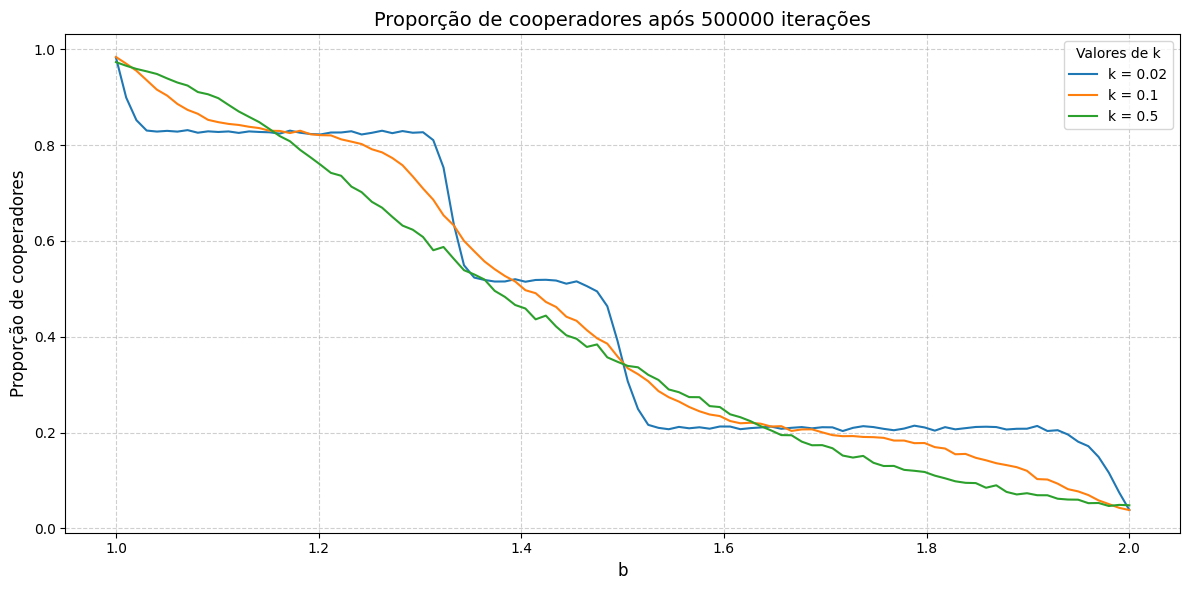

In [48]:
plotar_proporcoes(500000, 100)

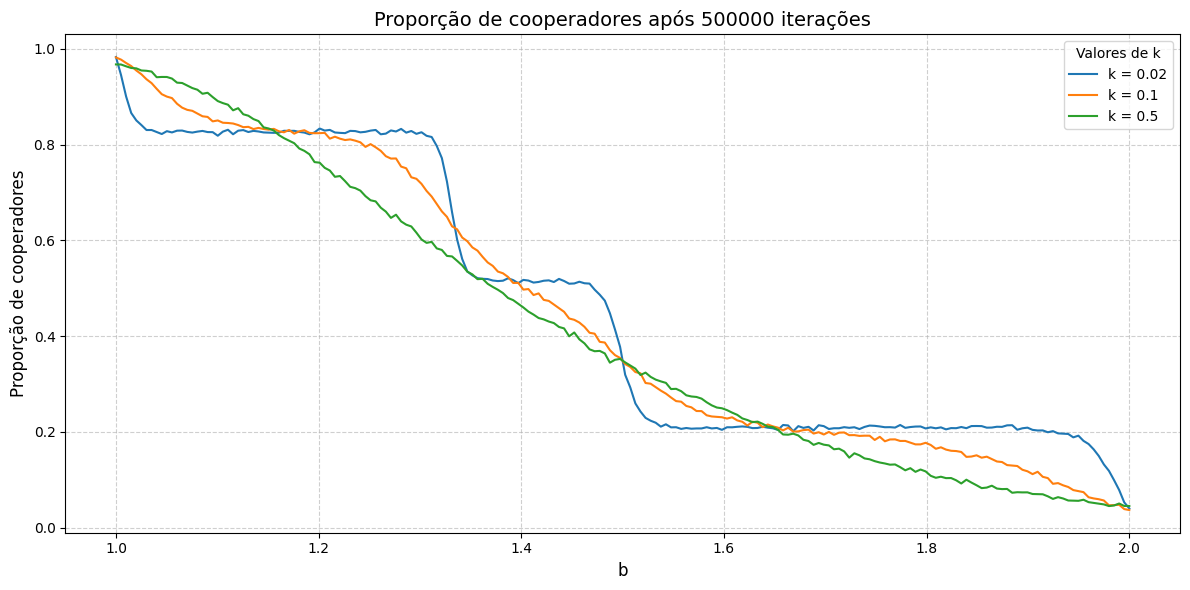

In [49]:
plotar_proporcoes(500000, 200)

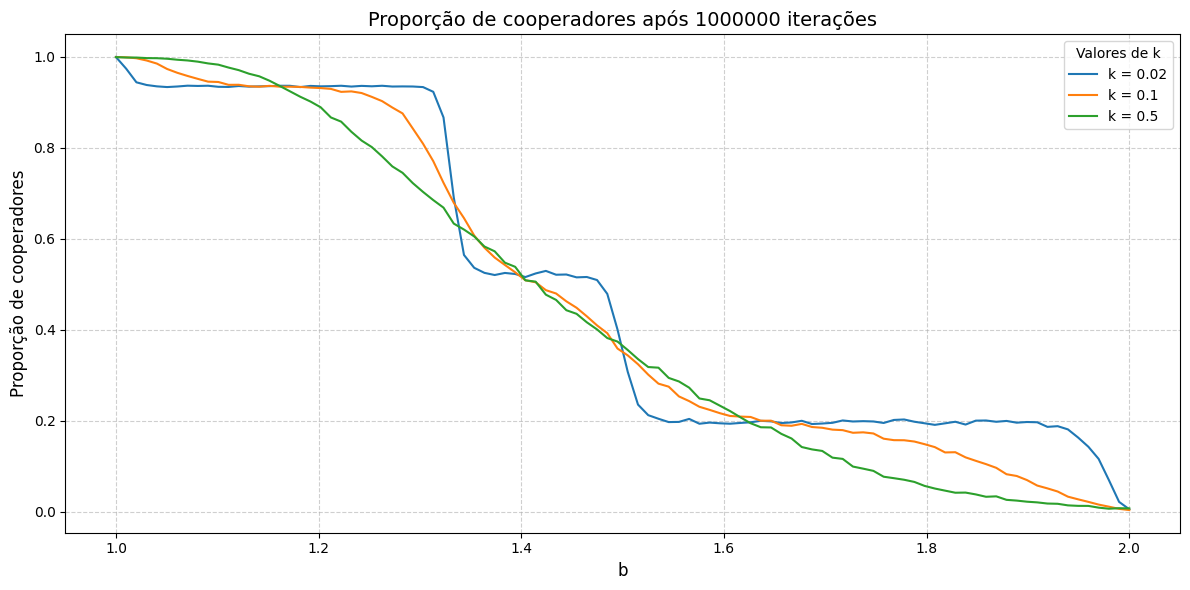

In [50]:
plotar_proporcoes(1000000, 100)

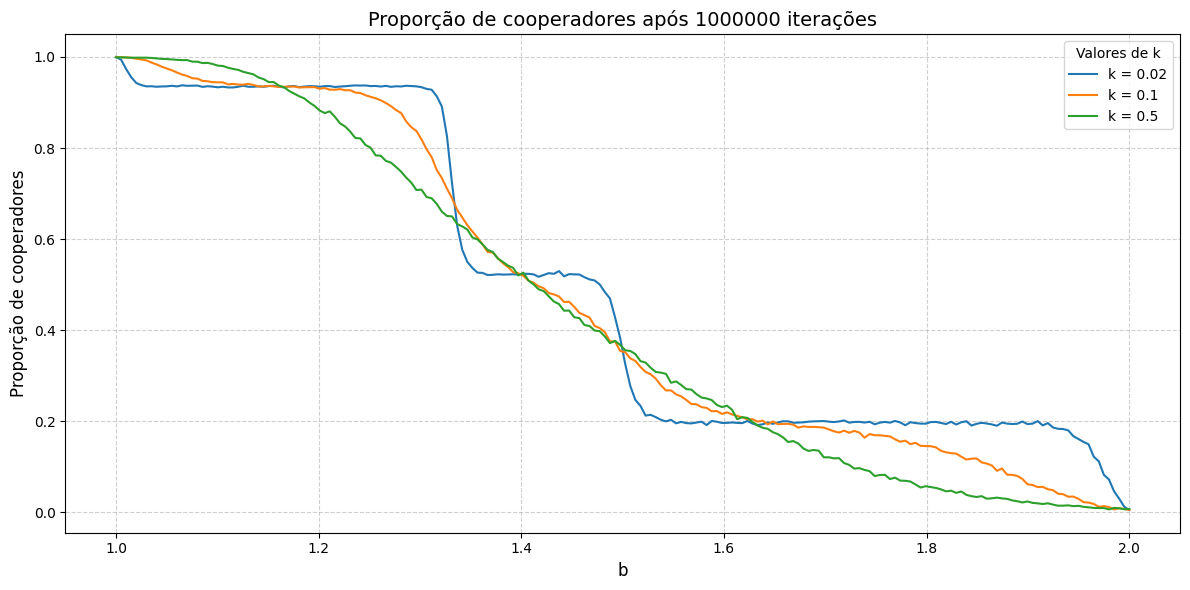

In [51]:
plotar_proporcoes(1000000, 200)

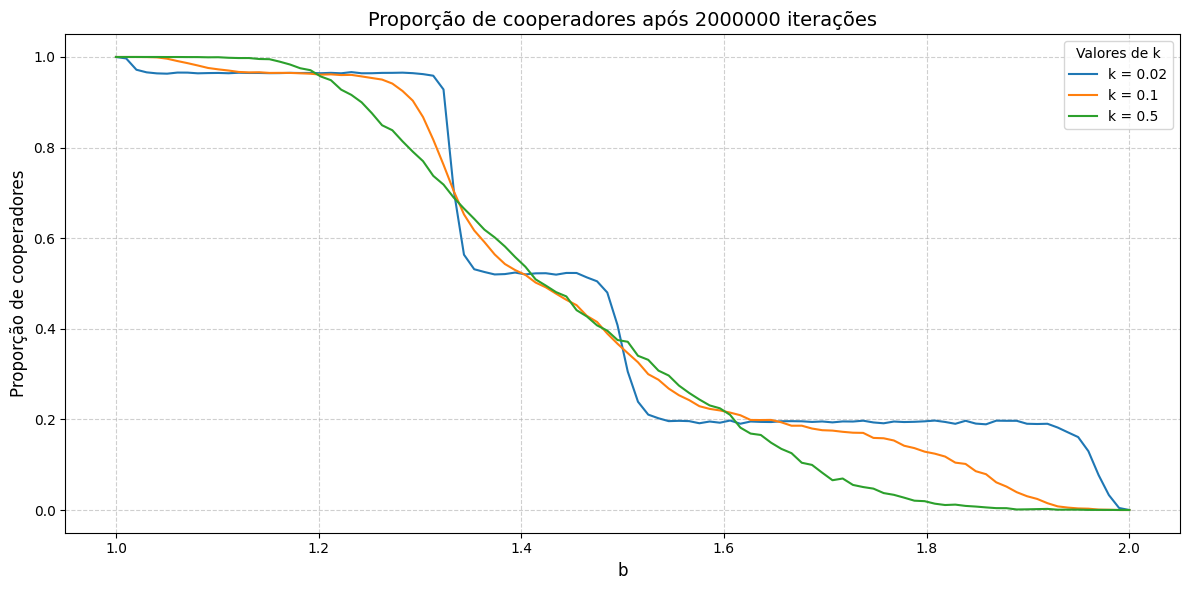

In [52]:
plotar_proporcoes(2000000, 100)

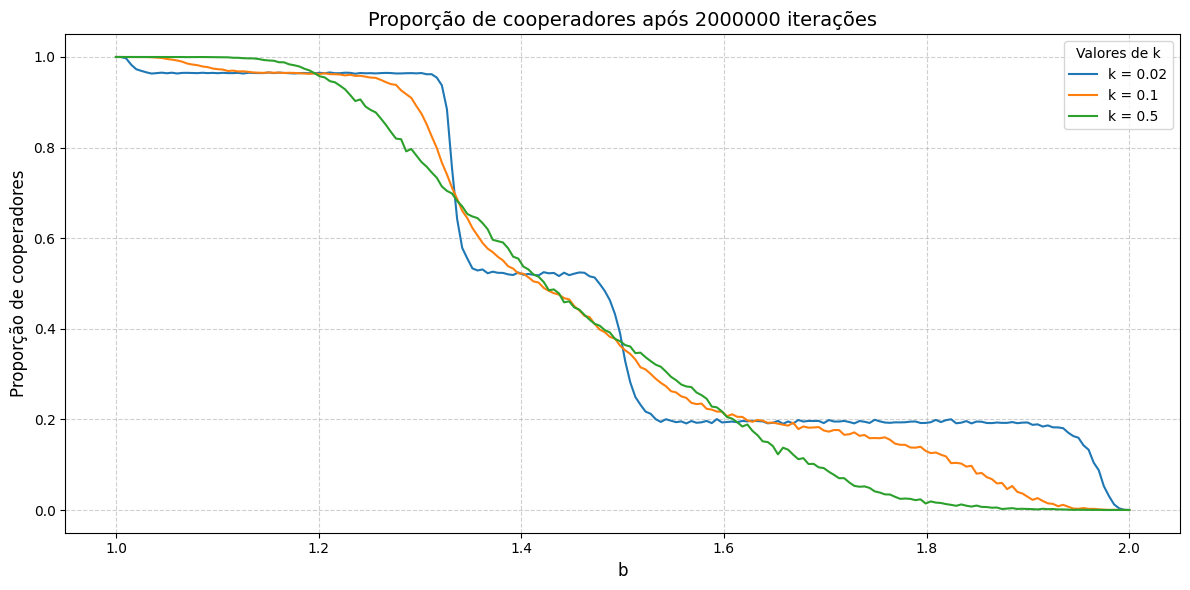

In [53]:
plotar_proporcoes(2000000, 200)

## Conclusão

### Sobre a alteração de K

Ao utilizar valores menores de K, nota-se uma maior dificuldade em identificar as transições de estado do sistema em poucas iterações, pois o intervalo de transição para determinar b1​ e b2​ não é facilmente perceptível. Por outro lado, quando K assume valores mais elevados, a mudança de estratégia ocorre de forma mais gradual, tornando as transições entre estados menos abruptas e mais suaves. Essa suavização reflete a maior influência da aleatoriedade nas decisões, típica de valores altos de K, o que aumenta a probabilidade de escolhas irracionais.

### Sobre a alteração do numero de interações

Com o aumento no número de iterações, torna-se possível observar as fases de transição do sistema de forma mais clara. Para K=0.02, o intervalo de transição ocorre aproximadamente entre b1​=1.3 e b2​=1.9, embora o gráfico ainda apresente certa irregularidade nas transições. Já para K=0.5, essas mudanças tornam-se mais evidentes, com os valores de b1​ e b2​ estimados em torno de 1.2 e 1.8, respectivamente. O aumento de K parece facilitar a identificação das transições, possivelmente devido à maior suavização das dinâmicas do sistema. Além disso, ao aumentar ainda mais o número de iterações, a transição torna-se ainda mais evidente. Com um valor elevado de K, que suaviza as mudanças de estratégia, o intervalo de transição passa a estar em torno de b1​=1.3 e b2​=1.7, reforçando o impacto do número de iterações na precisão da análise do sistema.

### Geral
No início, ao analisar os resultados, achei curioso o comportamento do gráfico, pois inicialmente esperava que, sendo K um 'fator irracional', seu aumento tornaria o gráfico menos previsível. No entanto, a análise mostrou que, ao aumentar K, torna-se mais fácil para os indivíduos mudarem de estratégia. Isso ocorre porque o fator irracional introduzido por K reduz a resistência às mudanças, permitindo que as decisões se direcionem mais facilmente para ações que prometem maior retorno imediato.

Nesse cenário, observa-se que, ao facilitar a troca de estratégias, K leva os prisioneiros a optar com maior frequência por decisões que maximizam os ganhos individuais no curto prazo, como trair. Isso acaba resultando em uma dinâmica onde, se ambos adotarem essa estratégia gananciosa, nenhum deles obtém lucro significativo. Assim, o aumento de K cria um ambiente mais competitivo e impulsivo, onde a decisão mais segura e cooperativa de não trair é abandonada com maior facilidade, evidenciando o impacto desse parâmetro na evolução do sistema e no comportamento dos agentes.